# Verify behavior cloning

Visually verify a behavior cloning based robot controller.

* Load the controller trained by the Train_BC notebook and the corresponding sp
* Choose a demonstration, to which the SP/BC pair will be applied to the images
* Visualize the path taken by the demonstration and what would be (autoregressively) recommended by the controller

In [1]:
import sys
sys.path.append("..")

from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

import pathlib
import pprint
import matplotlib.pyplot as plt

import torch
# import torch.nn as nn
# import torch.optim as optim
import numpy as np

from bc_trainingdata import create_trainingdata_bc
from bc_factory import create_bc_model

torch.manual_seed(1)
from sensorprocessing.sp_helper import get_transform_to_sp
from sensorprocessing.sp_factory import create_sp
from demonstration.demonstration import Demonstration

from robot.al5d_position_controller import RobotPosition

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

***ExpRun**: Loading pointer config file:
	C:\Users\lboloni\.config\BerryPicker\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\settings-LotziYoga.yaml
Using device: cuda


In [2]:
experiment = "behavior_cloning"
run = "bc_verify_mlp_00"
# run = "bc_verify_lstm_00"

exp = Config().get_experiment(experiment, run)
pprint.pprint(exp)

# Create the sp object described in the experiment
spexp = Config().get_experiment(exp["sp_experiment"], exp["sp_run"])
sp = create_sp(spexp, device)
transform = get_transform_to_sp(spexp)

# Load the bc model described in the experiment
bcexp = Config().get_experiment(exp["bc_experiment"], exp["bc_run"])
model, _, _ = create_bc_model(bcexp, spexp, device)
model_path = pathlib.Path(bcexp.data_dir(), bcexp["controller_file"])
model.load_state_dict(torch.load(model_path))

***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\behavior_cloning\bc_verify_mlp_00_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: behavior_cloning/bc_verify_mlp_00 successfully loaded
Experiment:
    bc_experiment: behavior_cloning
    bc_run: bc_mlp_00
    control_size: 6
    data_dir: c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-experiments\behavior_cloning\bc_verify_mlp_00
    epochs: 10
    exp_run_sys_indep_file: C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\behavior_cloning\bc_verify_mlp_00.yaml
    experiment_name: behavior_cloning
    loss: MSELoss
    optimizer: Adam
    optimizer_lr: 0.001
    run_name: bc_verify_mlp_00
    sequence_length: 10
    sp_experiment: sensorprocessing_conv_vae
    sp_run: sp_vae_256
    subrun_name: null
    test_data:
    - - random-both-cameras
      - '2025_03_08__14_23_19'
      

C:\Users\lboloni\AppData\Local\Temp\ipykernel_15100\472462191.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [5]:
a_real_list = []
a_pred_list = []
with torch.no_grad(): # disable gradient computation
    for val in exp["verification_data"]: # for all demonstrations
        run, demo_name, camera = val
        exp_demo = Config().get_experiment("demonstration", run)
        demo = Demonstration(exp_demo, demo_name)
        for i in range(demo.metadata["maxsteps"]-bcexp["sequence_length"]): # -1 because of lookahead
            if bcexp["sequence_length"]:
                input_list = []
                # FIXME make it sliding window
                for j in range(bcexp["sequence_length"]):
                    sensor_readings, _ = demo.get_image(i+j, device=device, transform=transform, camera=camera)
                    z = sp.process(sensor_readings)
                    input_list.append(z)
                    input_nd = np.array(input_list)
                    z_tensor = torch.tensor(input_nd).unsqueeze(0).to(device)
            else:
                sensor_readings, _ = demo.get_image(i, device=device, transform=transform, camera=camera)
                z = sp.process(sensor_readings)
                z_tensor = torch.tensor(z).unsqueeze(0).to(device)
            a_pred = model(z_tensor)
            a_pred_list.append(a_pred.to("cpu").squeeze(0))
            a = demo.get_action(i)
            rp = RobotPosition.from_vector(a)
            a_real = rp.to_normalized_vector()            
            a_real_list.append(a_real)

***ExpRun**: Experiment default config C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\demonstration\_defaults_demonstration.yaml was empty, ok.
***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\demonstration\random-both-cameras_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: demonstration/random-both-cameras successfully loaded


## Plot the differences between the a_real and a_pred

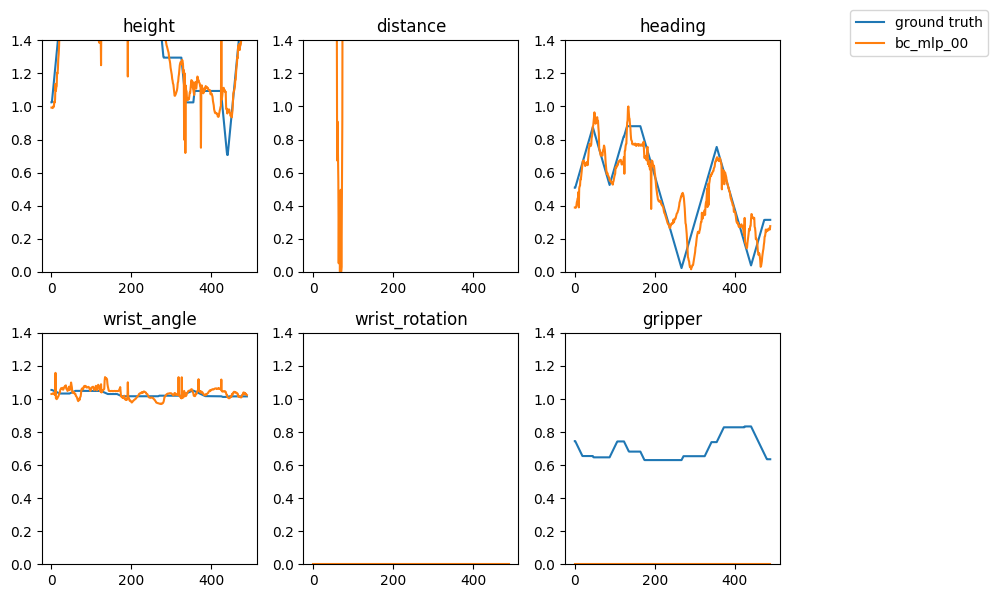

In [6]:
a_pred_np = np.array(a_pred_list)
a_real_np = np.array(a_real_list)

# save the comparison terms
pred_path = pathlib.Path(exp.data_dir(), "pred.npy")
np.save(pred_path, a_pred_np)
real_path = pathlib.Path(exp.data_dir(), "real.npy")
np.save(real_path, a_real_np)

fig, axs = plt.subplots(2,3, figsize=(8, 6))
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(bcexp["control_size"]):
    ax = axs[i//3, i%3]
    ax.set_ylim(0, 1.4)
    ax.plot(a_real_np[:,i], label="ground truth")
    ax.plot(a_pred_np[:,i], label=bcexp["name"])
    if i==0:
        fig.legend(bbox_to_anchor=(1.25, 1))
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(exp.data_dir(), "bccomparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')

In [ ]:
a_real_np.shape
a_real_np[:,1]

array([13.142858 , 13.142858 , 12.428572 , 11.714286 , 11.       ,
       10.285714 ,  9.571428 ,  8.857142 ,  8.669051 ,  8.669051 ,
        8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,
        8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,
        8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,
        8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,
        8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,
        8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,
        8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,
        8.669051 ,  7.954766 ,  7.24048  ,  6.526194 ,  5.8119087,
        5.097623 ,  4.383337 ,  3.6690514,  2.9547656,  2.799464 ,
        2.799464 ,  2.799464 ,  2.799464 ,  2.799464 ,  2.799464 ,
        2.799464 ,  2.799464 ,  2.799464 ,  2.799464 ,  2.799464 ,
        2.799464 ,  2.799464 ,  2.799464 ,  2.799464 ,  2.799464 ,
        2.799464 ,  2.799464 ,  2.799464 ,  2.799464 ,  2.7994

In [ ]:
a_pred_np.shape

(480, 10, 6)

In [ ]:
bcexp

Experiment:
    control_size: 6
    controller: bc_MLP
    controller_file: controller.pth
    data_dir: c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-experiments\behavior_cloning\bc_mlp_00
    epochs: 10
    exp_run_sys_indep_file: C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\behavior_cloning\bc_mlp_00.yaml
    experiment_name: behavior_cloning
    hidden_layer_1: 50
    hidden_layer_2: 20
    hidden_layers: 2
    loss: MSELoss
    name: bc_mlp_00
    optimizer: Adam
    optimizer_lr: 0.001
    run_name: bc_mlp_00
    sequence_lenght: 0
    sequence_length: 10
    sp_experiment: sensorprocessing_conv_vae
    sp_run: sp_vae_256
    subrun_name: null
    test_data:
    - - random-both-cameras
      - '2025_03_08__14_23_19'
      - dev2
    - - random-both-cameras
      - '2025_03_08__14_24_52'
      - dev2
    training_data:
    - - random-both-cameras
      - '2025_03_08__14_15_53'
      - dev2
    - - random-both-cameras
      - '2025_03_08__14